## Conversion rate significance ab experiment based on UI design of e-commerce details page


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy import stats

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  
a. Read in the dataset and take a look at the top few rows here:

In [ ]:
from google.colab import drive

# 连接到Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# 定义文件路径
file_path = '/content/drive/My Drive/gzj/offerrealize-ds小班课/项目/abtest/ab_data.csv'

# 使用pandas读取数据
df = pd.read_csv(file_path)

# 打印数据的前几行
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [ ]:
#show the total number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [ ]:
#calculare the number of unique user_id
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [ ]:
#calculate the converted users
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [ ]:
#treatment in group will be called A and new_page in landing_page will
#be called B

df_A_not_B = df.query('group == "treatment" & landing_page != "new_page"') # query是

df_B_not_A = df.query('group != "treatment" & landing_page == "new_page"')

#calculate thenumber of time new_page and treatment don't line up
len(df_A_not_B) + len(df_B_not_A)

3893

f. Do any of the rows have missing values?

In [ ]:
#view if there is any missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.


In [ ]:
#remove the mismatch rows
df1 = df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)

df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)

<ipython-input-11-d3ba01cf5549>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)


In [ ]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** to answer questions below.

a. How many unique **user_id**s are in **df2**?

In [ ]:
#calculare the number of unique user_id
len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [ ]:
#find out the duplicate user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**?

In [ ]:
#information found above, rows 1899 and 2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [ ]:
#remove one of the duplicated rows
df2.drop(labels=2893, inplace=True)

In [ ]:
#verify if number of rows have been drop by one
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** to answer the  questions below

a. What is the probability of an individual converting regardless of the page they receive?

In [ ]:
#calculate the averga of the converted column
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [ ]:
#view the probability of the converted rate for both control and treatment
#by applying method

df2.groupby(['group'],as_index=False)['converted'].mean().query('group == "control"')

,group,converted
0,control,0.120386


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [ ]:
#as above
df2.groupby(['group'],as_index=False)['converted'].mean().query('group == "treatment"')

,group,converted
1,treatment,0.118808


d. What is the probability that an individual received the new page?

In [ ]:
#retrieve the new_page values and compared with the total number of landing_page
#in order to obtain the probability that an individual that received the
#new_page was converted

round(len(df2.query('landing_page == "new_page"'))/len(df2.landing_page),4)

0.5001

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

This dataset includes two groups, old page (control) and new page (treatment), equally. The convert rate in this dataset is 11.96% regardless of pages. The convert rate in the old page is 12.04% than the convert rate in the new page, 11.88%. The differeence is only 0.15%, so it is very hard to tell which page leads to more conversions than another. We need to implement an experiment to see if the difference is statistically significant.

So, there is not sufficient evidence to say that the new treatment page leads to more conversions.

The test seems to be well designed. Half of the population received the old_page and half of the population received the new_page. The population is considerable in size (290584 users).

11.98% that received the old_page were converted. 11.88% that received the new_page were converted. In conclusion, the new_page did not increase the conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- <font color="red">Null hypothesis: the conversion rate of the old_page is greater or the same than the conversion rate of the new_page.</font>

$$p_{old} >= p_{new}$$

- <font color="blue">Alternative hypothesis: the conversion rate of the old_page is less than the conversion rate of the new_page.</font>


$$p_{old} < p_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  

a. What is the **convert rate** for $p_{new}$ under the null?

In [ ]:
#the Null hypothesis states there is not difference between the
#conversion rates of old and new page. Thus, the whole dataset is used to
#calculate the convertion rate for the new page (pnew).
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [ ]:
#the Null hypothesis states there is not difference between the
#conversion rates of old and new page. Thus, the whole dataset is used to
#calculate the convertion rate for the old_page (pold).
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [ ]:
#calculate the number of users landed and new_page
n_new = len(df2.query('landing_page == "new_page"'))

n_new

145310

d. What is $n_{old}$?

In [ ]:
#calculate the number of users landed and new_page
n_old = len(df2.query('landing_page != "new_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [ ]:

new_page_converted = np.random.binomial(1,p_new,n_new)

#new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.1200123873098892

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [ ]:
old_page_converted = np.random.binomial(1,p_old,n_old)

#old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.11995264121590925

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [ ]:
#since new_page_converted and old_page_converted have different sizes,
#I use the mean to get the difference
new_page_converted.mean() - old_page_converted.mean()

5.9746093979948234e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [ ]:
# run simulation 10000 times
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new).mean()
    old_page_converted = np.random.binomial(1,p_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

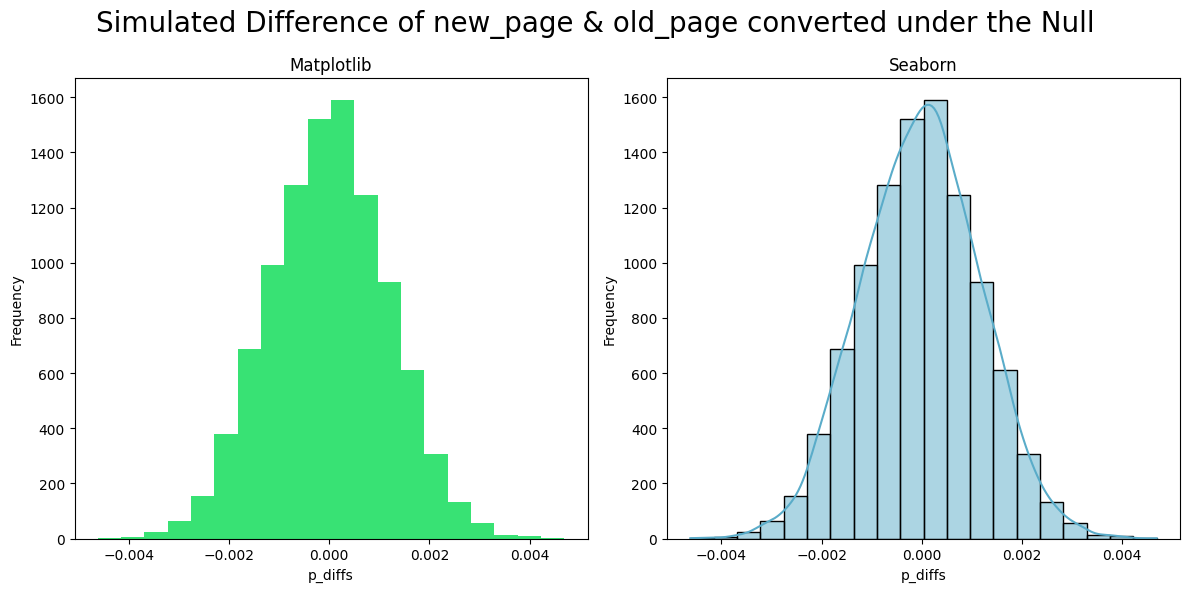

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# convert to numpy array
p_diffs = np.array(p_diffs)

# create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot histogram in the first subplot
ax1.hist(p_diffs, bins=20, color = '#38e274')
ax1.set_xlabel('p_diffs')
ax1.set_ylabel('Frequency')
ax1.set_title('Matplotlib')

# plot KDE curve in the second subplot
sns.histplot(p_diffs, bins=20, kde=True, ax=ax2, color = '#5aacc9')
ax2.set_xlabel('p_diffs')
ax2.set_ylabel('Frequency')
ax2.set_title('Seaborn')

fig.suptitle('Simulated Difference of new_page & old_page converted under the Null',fontsize = 20)

# adjust layout and show the plot
plt.tight_layout()
plt.show()


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [ ]:
df_control = df2.query('group == "control"')
df_treatment = df2.query('group == "treatment"')

# display observed difference
obs_diff = df_treatment.converted.mean() - df_control.converted.mean()
obs_diff

-0.0015782389853555567

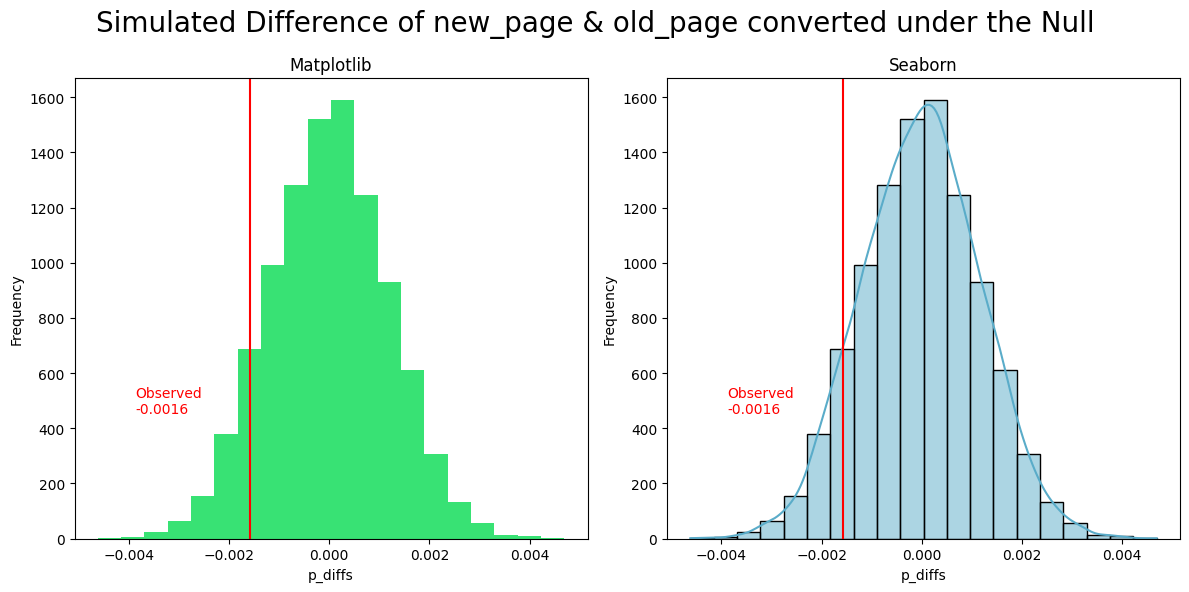

In [ ]:
# plot line for observed statistic

import matplotlib.pyplot as plt
import seaborn as sns

# convert to numpy array
p_diffs = np.array(p_diffs)

# create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot histogram in the first subplot
ax1.hist(p_diffs, bins=20, color = '#38e274')
ax1.axvline(x=obs_diff, color='r', label="Observed difference")
ax1.set_xlabel('p_diffs')
ax1.text(obs_diff - 0.0023, 500, f'Observed\n{obs_diff:.4f}', color='r', fontsize=10, verticalalignment='center')
ax1.set_ylabel('Frequency')
ax1.set_title('Matplotlib')

# plot KDE curve in the second subplot
sns.histplot(p_diffs, bins=20, kde=True, ax=ax2, color = '#5aacc9')
ax2.axvline(x=obs_diff, color='r', label="Observed difference")
ax2.set_xlabel('p_diffs')
ax2.text(obs_diff - 0.0023, 500, f'Observed\n{obs_diff:.4f}', color='r', fontsize=10, verticalalignment='center')
ax2.set_ylabel('Frequency')
ax2.set_title('Seaborn')

fig.suptitle('Simulated Difference of new_page & old_page converted under the Null',fontsize = 20)

# adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
#pvalue的一种算法
p_diffs = np.array(p_diffs)
sd = np.std(p_diffs)
z = (obs_diff - np.mean(p_diffs)) / sd
pvalue = 1 - stats.norm.cdf(z)
print(pvalue)

0.9072253703950091


In [ ]:
#pvalue的另一种算法
#calculate the proportion of p_diffs greater than the observe difference
(p_diffs > obs_diff).mean()

0.9028

91% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv.

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

91% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called p-value. This value means that we cannot reject the null hypothesis and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
import statsmodels.api as sm

n_new = len(df2.query('landing_page == "new_page"'))
n_old = len(df2.query('landing_page == "old_page"'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))


In [ ]:
convert_new, convert_old

(17264, 17489)

In [ ]:
n_new, n_old

(145310, 145274)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [ ]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is  larger than the old_page.

<a id='regression'></a>
### Part III - A regression approach（optional）

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

The dependent variable is a binary variable (converted vs not converted). Thus, you need to use a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis = 1)

df2.head()

,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [ ]:
df3 = df2.rename(columns={'treatment': 'ab_page'})
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0



c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [ ]:
from scipy import stats

df3['intercept'] = 1
df3 = df3.dropna()

lm = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 26 Aug 2023   Pseudo R-squ.:               8.077e-06
Time:                        10:45:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

解释如下：

- `from scipy import stats`：导入了 `scipy` 库中的 `stats` 模块，这是用于统计分析的模块。
- `df3['intercept'] = 1`：在数据框 `df3` 中新增一列名为 `intercept`，填充了全为 1 的值。这通常是逻辑回归中的截距项。
- `df3 = df3.dropna()`：删除数据框 `df3` 中包含缺失值的行。
- `lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])`：创建了一个逻辑回归模型对象 `lm`，其中因变量是 `df3` 数据框中的 `converted` 列（预计为二元响应变量），自变量是 `intercept` 列和 `ab_page` 列（预计为影响因子）。
- `results = lm.fit()`：用数据拟合逻辑回归模型，将结果存储在 `results` 变量中。
- `results.summary()`：打印输出逻辑回归模型的摘要统计信息，包括各个系数的估计值、标准误、z 值、p 值等。

In [ ]:
from sklearn.linear_model import LogisticRegression

# Import the LogisticRegression class from scikit-learn

# Add the intercept column
df3['intercept'] = 1

# Add an intercept column filled with ones to the DataFrame

# Drop rows with missing values
df3 = df3.dropna()

# Remove rows with missing values from the DataFrame

# Create a logistic regression model object
logreg = LogisticRegression()

# Instantiate a LogisticRegression model

# Fit the model
logreg.fit(df3[['intercept', 'ab_page']], df3['converted'])

# Fit the logistic regression model to the data
# Here, 'intercept' and 'ab_page' are used as predictor variables,
# and 'converted' is the target variable

# Print intercept and coefficient for 'ab_page'
print("Intercept:", logreg.intercept_)
print("Coefficient for ab_page:", logreg.coef_[0][1])

# Print the intercept (constant term) and the coefficient of 'ab_page'
# This coefficient represents the effect of 'ab_page' on the log-odds of the response variable

# You can use the predict method for making predictions or other operations
# predictions = logreg.predict(X_test)
# This line shows how to use the trained model to make predictions on new data

Intercept: [-1.98975361]
Coefficient for ab_page: -0.01499270145708004


An odds ratio of 1 implies no change in the odds. This means that the presence of the independent variable does not affect the odds of the dependent variable.

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

See above

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

For the hypothesis test in logistic regression, we calculate odds ratio (log(p/1-p)) and test that there is any relationship between convert rates and pages of groups.


Here, p-value is 0.19 which means there is no relationship between convert rates and pages of groups at a Type I error of 5%.


For the hypothesis tests in ab test and two sample proportion, we calculate the proportions in two groups and test that there is any difference of convert rates between new pages and old pages.


Here, p-value is 0.9 means that we cannot reject the null hypothesis, the convert rate in the old page is better than in the new page at a Type I error of 5%.

Because of different calculations, our p-values are different but we get the same conclusion.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to consider other factors in order to identify other potencial influences on the conversion rate.

A disadvantage is that the model gets more complex.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables.

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
countries_df = pd.read_csv('/content/drive/My Drive/gzj/offerrealize-ds小班课/项目/abtest/countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [ ]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [ ]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [ ]:
#mean of conversion rate
df_new.ab_page.mean()

0.5000619442226688

In [ ]:
#mean conversion rate by country
df_new.groupby(['country'], as_index=False).mean()

<ipython-input-64-504710461664>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['country'], as_index=False).mean()


,country,converted,ab_page,intercept
0,CA,0.115318,0.503552,1.0
1,UK,0.120594,0.498247,1.0
2,US,0.119547,0.500459,1.0


In [ ]:
#mean conversion rate by landing_page
df_new.groupby(['ab_page'], as_index=False).mean()

<ipython-input-65-b07633596b6b>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['ab_page'], as_index=False).mean()


,ab_page,converted,intercept
0,0,0.120386,1.0
1,1,0.118808,1.0


In [ ]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']]= pd.get_dummies(df_new['country'])

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [ ]:
### Fit Your Linear Model And Obtain the Results

df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 26 Aug 2023   Pseudo R-squ.:               2.323e-05
Time:                        10:47:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

The country does not appear to have influence on the convertion rate. P-values for the two dummy country variables are above 0.05. Note the CA variable get closes to 0.05.  

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
#mean conversion rate by country and landing_page -
#checking for possible interactions (whether the influence of landing_page
#is different for the countries)

df_new.groupby(['country','ab_page'], as_index=False).mean()

<ipython-input-68-5ef9ab549bc3>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new.groupby(['country','ab_page'], as_index=False).mean()


,country,ab_page,converted,intercept,CA,UK,US
0,CA,0,0.118783,1.0,1.0,0.0,0.0
1,CA,1,0.111902,1.0,1.0,0.0,0.0
2,UK,0,0.120022,1.0,0.0,1.0,0.0
3,UK,1,0.121171,1.0,0.0,1.0,0.0
4,US,0,0.120630,1.0,0.0,0.0,1.0
5,US,1,0.118466,1.0,0.0,0.0,1.0


By looking at an interaction, I will explore whether the influence of the landing_page might work in the US but not in the other countries, or Canada but not in other countries. Or the other way around.


In [ ]:
df_new.head()
df_new['interaction_us_ab_page'] = df_new.US *df_new.ab_page
df_new['interaction_ca_ab_page'] = df_new.CA *df_new.ab_page

df_new.head()


,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,interaction_us_ab_page,interaction_ca_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [ ]:
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','interaction_us_ab_page','CA','interaction_ca_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 26 Aug 2023   Pseudo R-squ.:               3.482e-05
Time:                        10:47:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page                    0.0108      0.023      0.475      0.635      -0.034       0.056
US                         0.0057      0.019      0.306      0.760      -0.031       0.043
interaction_us_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA                        -0.0118      0.040     -0.296      0.767      -0.090       0.066
interaction_ca_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==========================================================================================
"""

In [ ]:
# Create a logistic regression model object
logreg = LogisticRegression()

# Fit the model
X = df_new[['ab_page', 'US', 'interaction_us_ab_page', 'CA', 'interaction_ca_ab_page']]
y = df_new['converted']
logreg.fit(X, y)

# Output coefficients
coefficients = logreg.coef_
intercept = logreg.intercept_
print("Intercept:", intercept)
print("Coefficients:", coefficients)


Intercept: [-1.99217161]
Coefficients: [[ 0.01071148  0.00570599 -0.03126899 -0.0118572  -0.07812497]]


### Summary and conclusion on regression

The p_value for both interaction terms is higher than 0.05.

Thus, the influence of landing_page in the US is not different to the influence of landing_page in the other countries.

And the influence of landing_page in Canada is not different to the influence of landing_page in the other countries.

<a id='conclusions'></a>
## Conclusions

In conclusion, there is not enough evidence that the new_page increases the conversion rate as compared to the old_page. This is based on the probability figures, A/B testand regression. There is no strong evidence that the countries (US, CA and UK) influence the conversion rate.

Since the sample size is large continuing the testing of the new_page is likely not necessary. It is best to focus on the development of another new landing page.

